In [1]:
import re
import json
import random
import numpy as np
import pandas as pd 
from glob import glob

from textwrap import wrap
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px

from pymagnitude import *
from tqdm import tqdm 

%matplotlib inline
import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

def grey_color_func(**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

## plot settings

In [2]:
rcParams['figure.figsize'] = 18, 10
plt.rcParams.update({'font.size': 20})
plt.style.use('seaborn-ticks')

In [3]:
with open('../generated_material/Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)
    
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

## Load the representative Articles of each Community and append limited amount of them to the Dataframe

In [4]:
repr_files = glob("../representatives/secondRun/*.csv")

repr_articles_df = pd.DataFrame()

max_articles_perCom = 750
for repr_file in repr_files:
    repr_df = pd.read_csv(repr_file)
    repr_articles_df = repr_articles_df.append(repr_df[:max_articles_perCom])

In [5]:
repr_articles_df.head(5)

ID_Article  communityId  ID_RelatedVenue  \
0     3052207        20178              369   
1     2847777        20178              369   
2     3007663        20178              369   
3     2875774        20178              369   
4     3107243        20178              369   

                                               title  year  \
0  Green Cellular Demand Control with User-in-the...  2016   
1  Synthesis of Radiation Patterns in Arbitrary G...  2016   
2  R-OFDM Transmission Scheme for Visible Light C...  2016   
3  A Study on Channel Modeling in Tunnel Scenario...  2016   
4  Indoor Channel Measurements Using a 28GHz mult...  2016   

                                            abstract  
0  Mobile communications demand for data grows al...  
1  A novel algorithm is presented for determining...  
2  White light-emitting diode (LED) consisting of...  
3  A new approach based on conventional propagati...  
4  Millimeter-wave (mmW) wireless is as a promisi...

In [6]:
repr_articles_df['communityId'].value_counts()

20178    750
21212    750
21220    750
21235    750
21239    750
21246    750
21349    750
22457    750
22736    750
21258    739
Name: communityId, dtype: int64

## No. of representative Articles published per Year (all communities combined)
to see which years account for majority of the years presented in

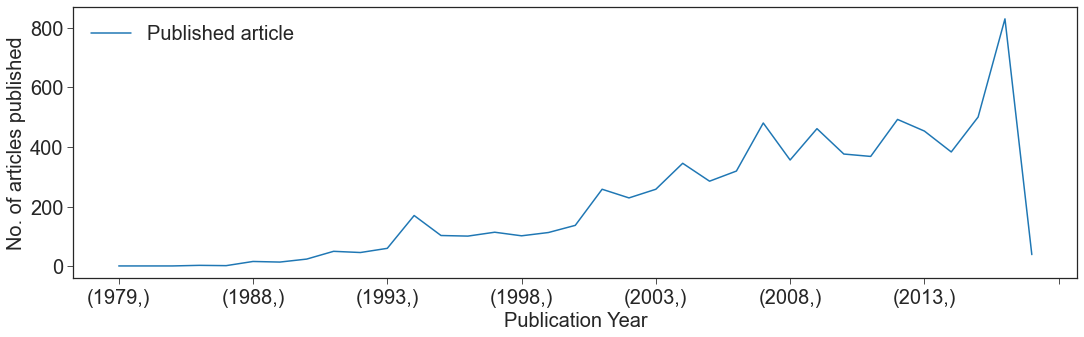

In [7]:
ax = repr_articles_df[['year']].sort_values(by='year').value_counts(sort=False).plot(figsize=(18,5))
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of articles published')
# plt.title('Distribution of articles against the year it was presented in')
plt.legend(["Published article"])
plt.show()

## No. of Articles per year for each Community

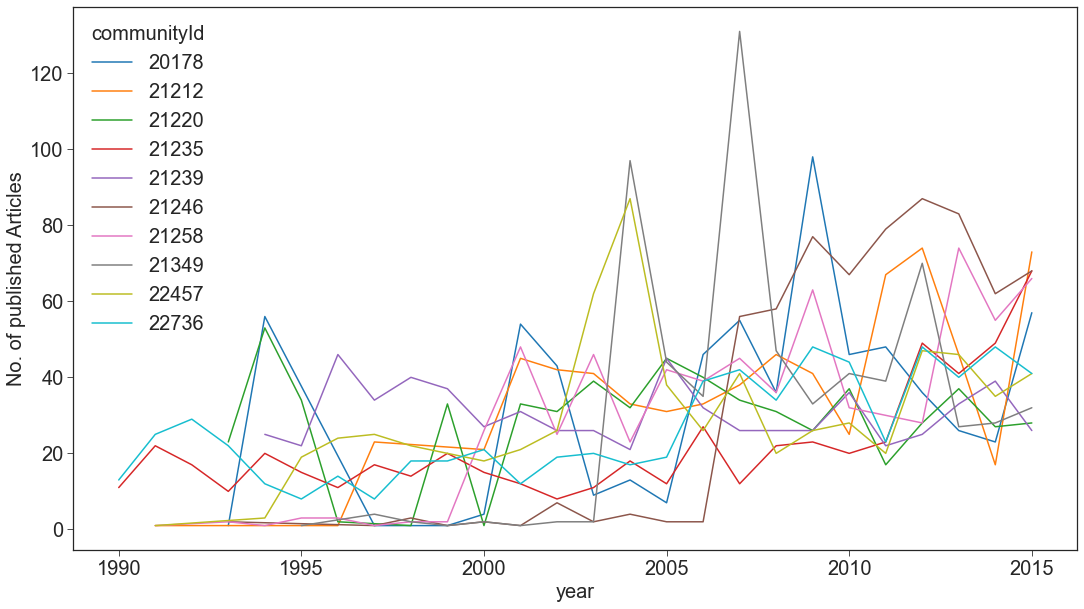

In [8]:
# plt.rcParams.update({'font.size': 22})
# rcParams['figure.figsize'] = 18,8
for comm in repr_articles_df.communityId.unique():
    to_plot = repr_articles_df[(repr_articles_df['communityId'] == comm) & (repr_articles_df['year'] >= 1990) & (repr_articles_df['year'] <= 2015)].sort_values(by='year')['year'].value_counts(sort=False)
    years = to_plot.index
    counts = to_plot.values
    plt.plot(years, counts, label = comm)
# plt.title('Distribution of articles of the different communities against the year it was presented in')
plt.legend()
plt.xlabel("year")
plt.ylabel("No. of published Articles")
plt.legend(title="communityId")
plt.show()

### List the conference names for each venue Id

In [9]:
confs = repr_articles_df.groupby("ID_RelatedVenue").filter(lambda x: len(x) > 20)['ID_RelatedVenue'].unique()

for conf in confs:
    print(f"{conf}: {conference_data_dict[conf]}")

369: vehicular technology conference
8228: international conference on communications
8494: international symposium on circuits and systems
10228: wireless communications and networking conference
9078: international conference on image processing
21106: international conference on computer vision
23735: intelligent robots and systems
9475: conference on decision and control
422: knowledge discovery and data mining
256: international conference on learning representations
8960: neural information processing systems
20358: international world wide web conferences
9616: international conference on pattern recognition
11321: international conference on machine learning
11166: international conference on data mining
11104: international geoscience and remote sensing symposium
20332: national conference on artificial intelligence
9463: north american chapter of the association for computational linguistics
9099: acm multimedia
9804: conference of the international speech communication assoc

### Dict with the original Venue Abbreviations 

In [10]:
conf_abbvs = { 11104: 'IGARSS', 535: 'ASRU', 256: 'ICLR', 9463: 'NAACL', 390: 'ISBI', 8960: 'NIPS', 8441: 'ACC', 65: 'RO-MAN', 11166: 'ICDM', 9804: 'ISCA', 422: 'KDD', 20332: 'AAAI', 20561: 'HICSS', 9896: 'CSCW', 20358: 'WWW', 11321: 'ICML', 9475: 'CDC', 8806: 'SAC', 21106: 'ICCV', 30: 'EMBC', 11470: 'ICME', 10228: 'WCNC', 8494: 'ISCAS', 369: 'VTC', 23735: 'IROS', 8502: 'WACV', 9616: 'ICPR', 8228: 'ICC', 9099: 'ACM', 9078: 'ICIP' }

### Show for each venue how many articles per community were published and use the venue Ids with the Abbreviations

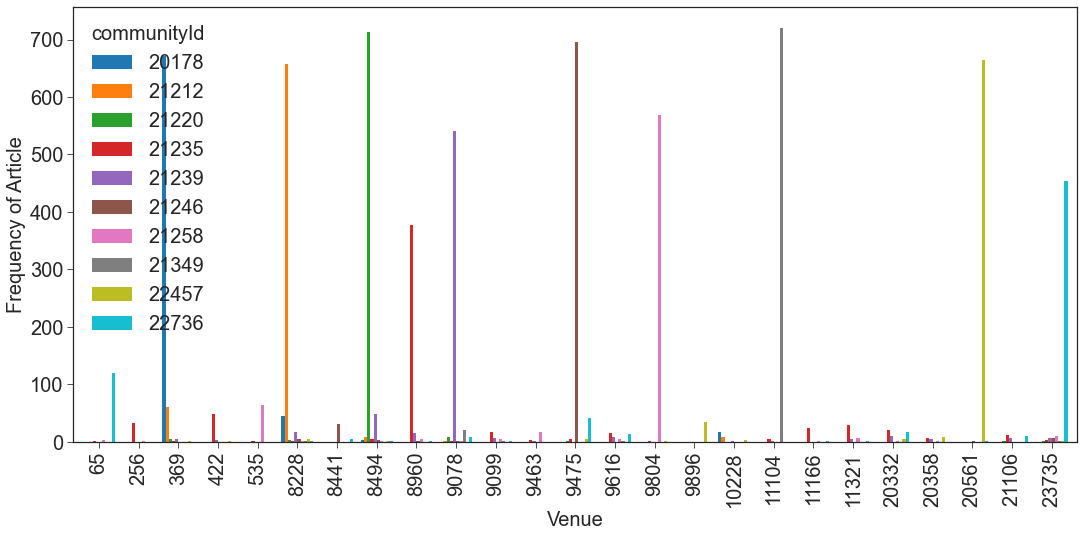

In [11]:
plt.rcParams.update({'font.size': 20})
rcParams['figure.figsize'] = 18,8

plot_df = repr_articles_df.groupby("ID_RelatedVenue").filter(lambda x: len(x) > 20)
# plot_df['ID_RelatedVenue'] = plot_df['ID_RelatedVenue'].apply(lambda x: conf_abbvs[x])
results = pd.crosstab(plot_df['ID_RelatedVenue'], plot_df['communityId'])
results.plot.bar(width=0.8)
plt.xlabel("Venue")
plt.ylabel("Frequency of Article")
plt.show()

Um die Artikel Communityübergreifend zu analysieren, werden jetzt nur die Titel der Artikel genutzt. Könnte auch die Abstracts nehmen, aber das macht ja nicht so einen großen Unterschied, wie man in den einzelnen Analysen auch schon gesehen hat. Spart Memory und machts auch einfacher.

In [12]:
titles_df = pd.DataFrame()
stop_words.update(['based', 'using', 'A', 'The', 'system', 'algorithm'])

titles_df['processed_words'] = repr_articles_df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
titles_df['processed_words'] = titles_df.apply(lambda row: row['processed_words'].lower(), axis = 1)
titles_df['processed_words'] = titles_df.apply(lambda row: (word_tokenize(row['processed_words'])), axis = 1)
titles_df['processed_words'] = titles_df.apply(lambda row: ([w for w in row['processed_words'] if w not in stop_words]), axis=1)
titles_df['processed_words'] = titles_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['processed_words']]), axis=1)
titles_df['concatenated_words'] = titles_df.apply(lambda row: ' '.join(row['processed_words']), axis=1)
titles_df['communityId'] = repr_articles_df['communityId']
titles_df['ID_Article'] = repr_articles_df['ID_Article']

### Top 15 Words Distribution across Communities

Plotting der 15 meist verwendeten Wörter und die dazugehörige Verteilung.
Jedes Wort bekommte eine bar und die Verteilung über die Communities für dieses Wort wird gefärbt für jede einzelne Community

In [13]:
top_15_words = pd.Series(' '.join(titles_df['concatenated_words']).split()).value_counts()[:15].index.to_list()

community_word_freqs = list()
for word in top_15_words:
    word_freq_list = list()
    for communityId in titles_df['communityId'].unique():
        df_ = titles_df[titles_df['communityId'] == communityId]
        word_freq_list.append(df_.concatenated_words.str.count(word).sum())
    community_word_freqs.append(word_freq_list)
    
df_list, cols = list(), list()

for word, counts in zip(top_15_words, community_word_freqs):
    df_list.append([word] + counts)

cols = ['Word'] + [community for community in titles_df['communityId'].unique()]

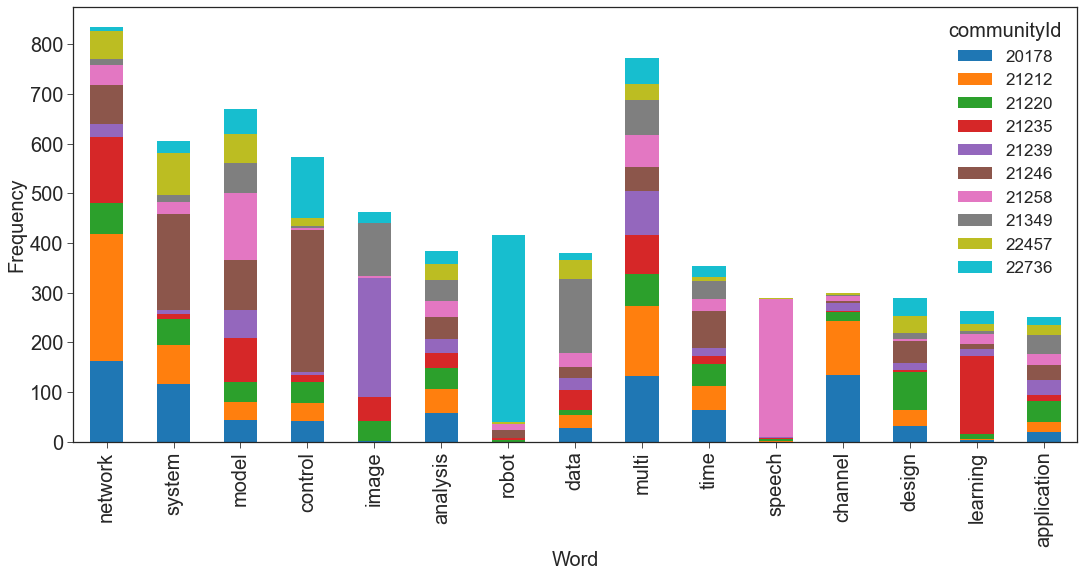

In [14]:
# plt.rcParams.update({'font.size': 20})

freq_df = pd.DataFrame(df_list, columns=cols)
freq_df.plot(x='Word',kind='bar', stacked=True)
plt.legend(title="communityId", fontsize=17)
plt.ylabel("Frequency")
plt.show()

## Wordcloud Visualization

Wordcloud for each community to see which are the most common terms and words that appear in the titles of the articles. 
To get an idea of what the topics of the community are.

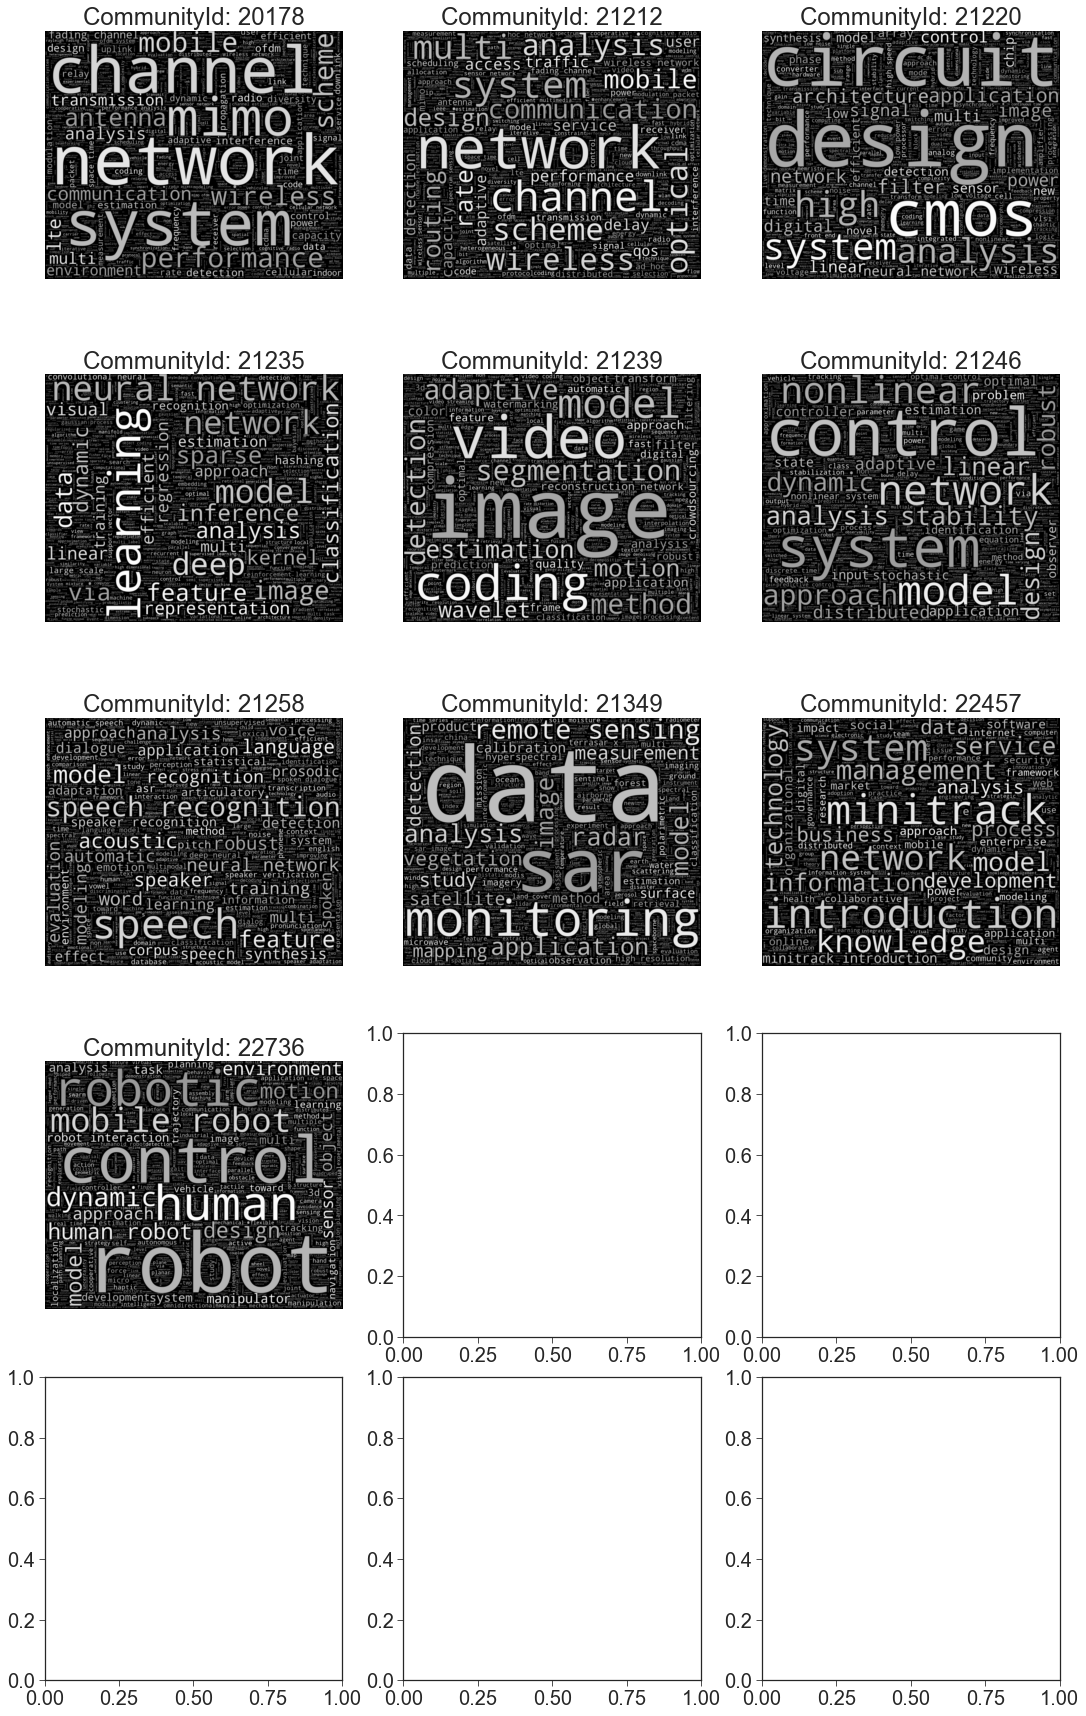

In [15]:
figure, axis = plt.subplots(5,3, figsize=(15,24))
# Function for generating word clouds
def generate_wordcloud(data, communityId, x,y):
    wc = WordCloud(background_color="black", max_words=2000, stopwords=stop_words.update([]), width=1200, height=1000)
    wc.generate(" ".join(data))
    wc.recolor(color_func=grey_color_func, random_state=17)
    # axis[y,x].figure(figsize=(15,8))
    axis[y,x].imshow(wc, interpolation='bilinear')
    axis[y,x].axis("off")
    axis[y,x].title.set_text('\n'.join(wrap('CommunityId: ' + str(communityId),60)))

# Plotting word cloud for each communityId
for i,communityId in enumerate(plot_df['communityId'].unique()):
    word_data = titles_df[titles_df['communityId'] == communityId]['concatenated_words'].values
    generate_wordcloud(word_data, communityId, i%3, int(i/3))
plt.tight_layout(pad=0.2)

## Visualizing titles of the articles onto 2D Space through t-SNE

1. FastText Embedding der Title
2. Reduktion der Dimensionen auf 2D mithilfe von t-SNE
3. pyMagnitude für vektorisierung der Daten (jedes Word wird gewichtet nach dem entsprechenden Durchschnitt. Insgesammt entsteht ein 300-D Vektor)
Gewichtungen mithilfe der Inverse Document Frequency (IDF) (Spiegelt wieder, wie oft das Wort im Verhältnis zu allen Wörtern vorkommmt)
(Anzahl aller Dokumente) / (Anzahl der Dokumente, die das Wort beinhalten)

In [16]:
# Magnitude File: http://magnitude.plasticity.ai/fasttext/medium/wiki-news-300d-1M-subword.magnitude
fasttext = Magnitude("vectors/wiki-news-300d-1M-subword.magnitude")

### Inverse Document Frequency Vectors for each community (idf score assignment to each word)

In [17]:
idf_dicts = dict()

for comm in titles_df['communityId'].unique():
    tfidf = TfidfVectorizer()
    tfidf.fit(titles_df[titles_df['communityId'] == comm]['concatenated_words'].values)
    idf_dicts[comm] = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

### Every article title gets a vector based of the average of the specific word vectors (weighted by the idf scores)

In [18]:
def idf_fasttext(df):
    vectors = []
    for title, comm in tqdm(zip(df.title.values, df.communityId.values)):
        fasttext_vectors = fasttext.query(word_tokenize(title))
        weights = [idf_dicts[comm].get(word, 1) for word in word_tokenize(title)]
        vectors.append(np.average(fasttext_vectors, axis = 0, weights = weights))
    return np.array(vectors)

vectors = idf_fasttext(repr_articles_df)

7489it [02:12, 56.56it/s] 


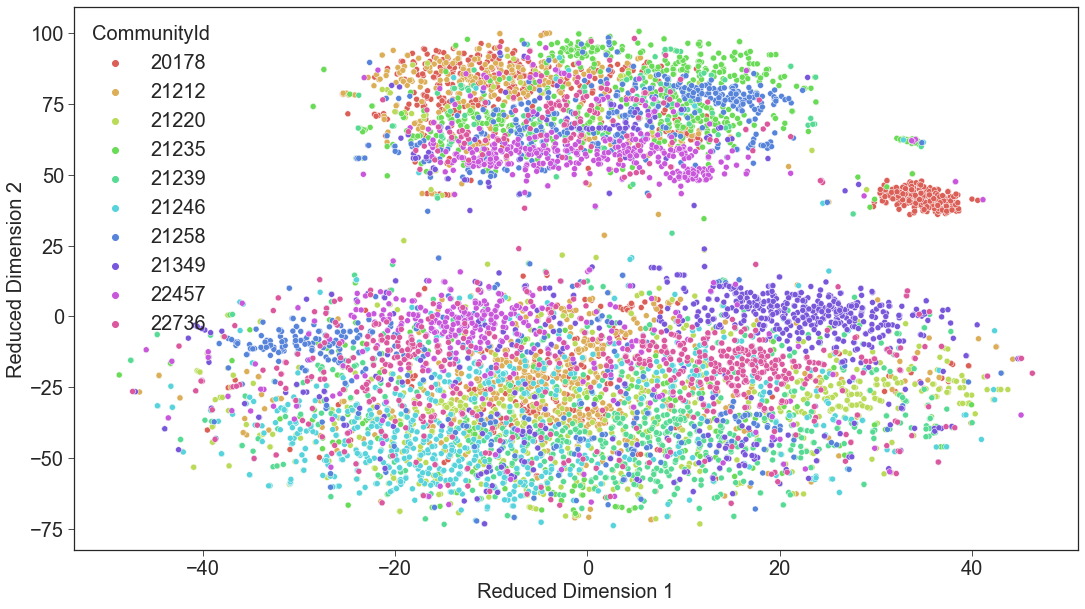

In [19]:
rcParams['figure.figsize'] = 18, 10
tsne = TSNE(n_components = 2, n_jobs= -1, verbose = 0, perplexity = 50, n_iter=2500)
tsne_data = tsne.fit_transform(vectors)

tsne_data = pd.DataFrame(tsne_data, columns = ['Reduced Dimension 1', 'Reduced Dimension 2'])
tsne_data['CommunityId'] = titles_df['communityId'].values

sns.scatterplot(x = 'Reduced Dimension 1', y = 'Reduced Dimension 2', hue='CommunityId', palette=sns.color_palette("hls", 10), data = tsne_data)
# plt.title('TSNE on IDF-Fasttext Title Embeddings')

plt.show()

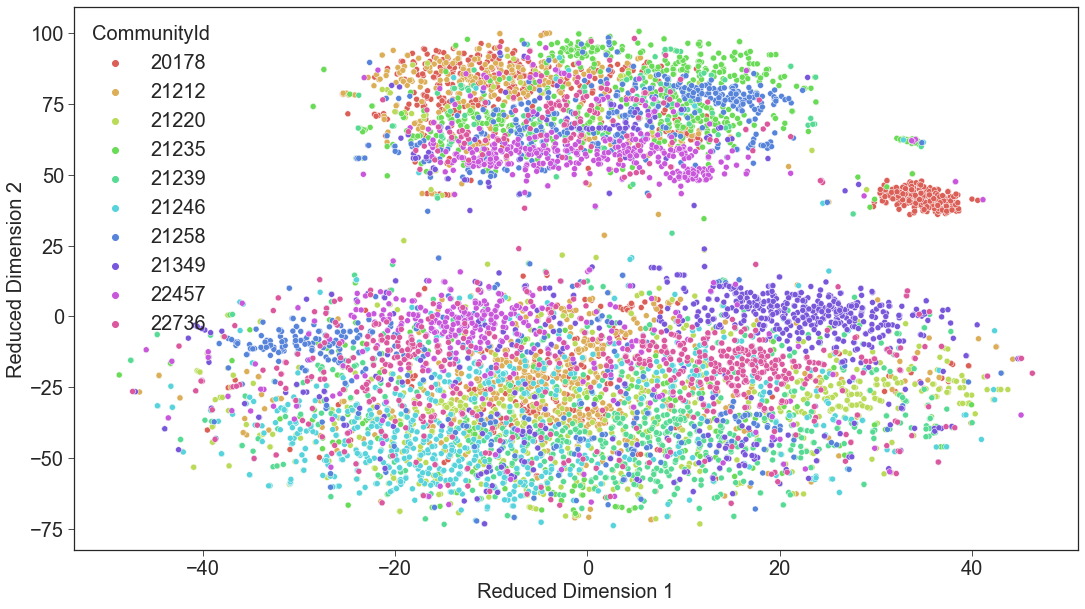

In [20]:
sns.scatterplot(x = 'Reduced Dimension 1', y = 'Reduced Dimension 2', hue='CommunityId', palette=sns.color_palette("hls", 10), data = tsne_data)
# plt.title('TSNE on IDF-Fasttext Title Embeddings')

plt.show()

Als nächstes noch die Visualisierung in 3 Dimensionen

In [21]:
tsne_3d = TSNE(n_components = 3, n_jobs= -1, verbose = 0, perplexity = 100, n_iter=5000)
tsne_data_3d = tsne_3d.fit_transform(vectors)

tsne_data_3d = pd.DataFrame(tsne_data_3d, columns = ['Reduced Dimension 1', 'Reduced Dimension 2', 'Reduced Dimension 3'])
tsne_data_3d['communityId'] = titles_df['communityId'].values
tsne_data_3d['communityId'] = tsne_data_3d['communityId'].astype('str')
tsne_data_3d = tsne_data_3d.drop([5951], axis='index') # Removing an outlier which affects the visualization of the plot


In [22]:
fig = px.scatter_3d(tsne_data_3d, x='Reduced Dimension 1', y='Reduced Dimension 2', z='Reduced Dimension 3', color='communityId', 
                    color_discrete_sequence=px.colors.qualitative.D3)
fig.update_layout(
    autosize=False,
    width=850,
    height=700,
)
fig.update_traces(marker={'size': 4})

fig.show()

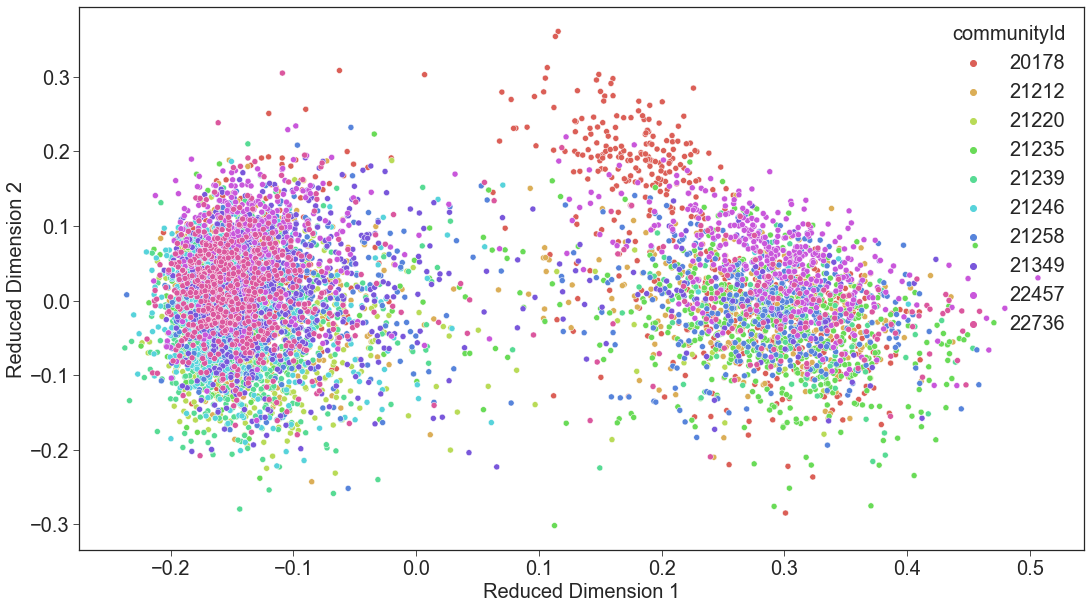

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(vectors)

pca_data = pd.DataFrame(pca_data, columns = ['Reduced Dimension 1', 'Reduced Dimension 2'])
pca_data['communityId'] = titles_df['communityId'].values

sns.scatterplot(x = 'Reduced Dimension 1', y = 'Reduced Dimension 2', hue='communityId', palette=sns.color_palette("hls", 10), data = pca_data)

plt.show()

In [24]:
pca_3d = PCA(n_components = 3)
pca_data_3d = pca_3d.fit_transform(vectors)

pca_data_3d = pd.DataFrame(pca_data_3d, columns = ['Reduced Dimension 1', 'Reduced Dimension 2', 'Reduced Dimension 3'])
pca_data_3d['communityId'] = titles_df['communityId'].values
pca_data_3d['communityId'] = pca_data_3d['communityId'].astype('str')
pca_data_3d = pca_data_3d.drop([5951], axis='index') # Removing an outlier which affects the visualization of the plot

In [25]:
fig = px.scatter_3d(pca_data_3d, x='Reduced Dimension 1', y='Reduced Dimension 2', z='Reduced Dimension 3', color='communityId', 
                    color_discrete_sequence=px.colors.qualitative.D3)
fig.update_layout(
    autosize=False,
    width=850,
    height=700,
)
fig.update_traces(marker={'size': 4})

fig.show()